In [2]:
import pandas as pd

# Import Dataset
parcel_data = pd.read_csv('../data/cleaned/fy2023-property-assessment-data-cleaned.csv')

In [3]:
from sklearn.model_selection import train_test_split

# assuming the data is in a dataframe named 'parcel_data'
X = parcel_data.drop(['TOTAL_VALUE'], axis=1)
y = parcel_data['TOTAL_VALUE']

# Split the data into training and test sets (30% held out for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Define categorical pipeline
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVR

# Define categorical and numerical features
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

linear_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', random_state=42)

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_svr)
])
pipe.fit(X_train, y_train)

# Evaluate the model on the test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = pipe.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

Categorical columns are: ['CITY', 'LU', 'LU_DESC', 'BLDG_TYPE', 'OWN_OCC', 'STRUCTURE_CLASS', 'ROOF_STRUCTURE', 'ROOF_COVER', 'EXT_FNISHED', 'INT_COND', 'EXT_COND', 'OVERALL_COND', 'BDRM_COND', 'KITCHEN_TYPE', 'HEAT_TYPE', 'HEAT_FUEL', 'AC_TYPE', 'ORIENTATION', 'PROP_VIEW', 'CORNER_UNIT']
Numerical columns are: ['ZIP_CODE', 'LUC', 'LAND_SF', 'GROSS_AREA', 'YR_BUILT', 'YR_REMODEL', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'KITCHENS', 'TT_RMS', 'FIREPLACES', 'NUM_PARKING']
MAE: 1071263.5720315347
RMSE: 9709098.779189331
R2: 0.7112709501082792


In [5]:
from sklearn.feature_selection import SelectPercentile, r_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the pipeline for polynomial regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selectpercentile', SelectPercentile(score_func=r_regression)),
    ('model', linear_svr)
])

# Define the hyperparameter grid to search over
param_grid = {
    'selectpercentile__percentile': np.logspace(.3, 1, 10),  # Percentiles of features to keep
    'model__C': np.logspace(.5, 2.5, 9),  # Regularization parameter
    'model__epsilon': np.logspace(-3, .5, 8)  # Epsilon-insensitive loss parameter
}

# Perform grid search using cross-validation to find the best hyperparameters
grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid, scoring='r2', verbose=2)
grid.fit(X_train, y_train)

# Evaluate the best model on the validation set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = best_model.score(X_test, y_test)

# Print the results
print(f"Best feature percentile: {best_model.named_steps['selectpercentile'].percentile}")
print(f"Best C: {best_model.named_steps['model'].C}")
print(f"Best epsilon: {best_model.named_steps['model'].epsilon}")
print(f"Validation RMSE: {rmse}")
print(f"Validation R2: {r2}")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=1.9952623149688795; total time=   1.6s
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=1.9952623149688795; total time=   1.4s
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=1.9952623149688795; total time=   1.6s
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=1.9952623149688795; total time=   1.6s
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=1.9952623149688795; total time=   1.6s
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=2.386589786858581; total time=   1.5s
[CV] END model__C=3.1622776601683795, model__epsilon=0.001, selectpercentile__percentile=2.386589786858581; total time=   1.5s
[CV] END model__C=3.1622776601683795, mode

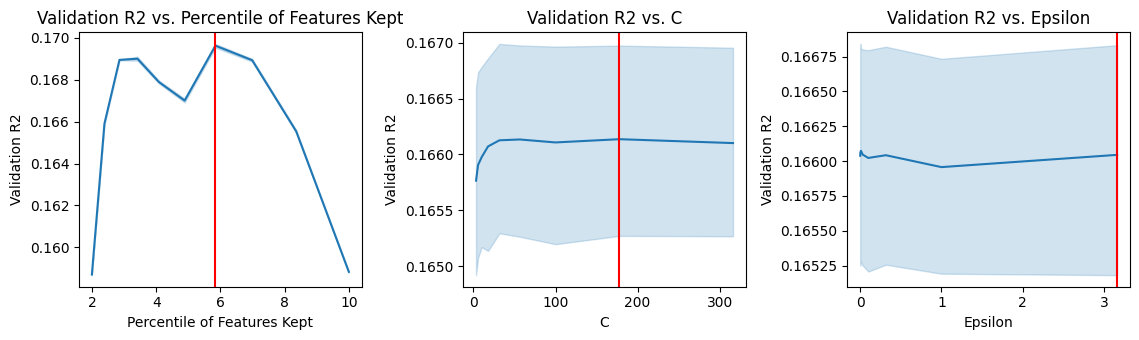

In [23]:
# Graph GridSearchCV results
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the results of the grid search
results = pd.DataFrame(grid.cv_results_)
results['percentile'] = results['param_selectpercentile__percentile'].astype(float)
results['C'] = results['param_model__C'].astype(float)
results['epsilon'] = results['param_model__epsilon'].astype(float)

# Plot the results of the grid search
fig, ax = plt.subplots(1, 3, figsize=(11.5, 3.5))
sns.lineplot(x='percentile', y='mean_test_score', data=results, ax=ax[0])
sns.lineplot(x='C', y='mean_test_score', data=results, ax=ax[1])
sns.lineplot(x='epsilon', y='mean_test_score', data=results, ax=ax[2])
# Mark the best parameters
ax[0].axvline(best_model.named_steps['selectpercentile'].percentile, color='red')
ax[1].axvline(best_model.named_steps['model'].C, color='red')
ax[2].axvline(best_model.named_steps['model'].epsilon, color='red')
# Set the x-axes to log scale
ax[0].set_title('Validation R2 vs. Percentile of Features Kept')
ax[1].set_title('Validation R2 vs. C')
ax[2].set_title('Validation R2 vs. Epsilon')
ax[0].set_xlabel('Percentile of Features Kept')
ax[1].set_xlabel('C')
ax[2].set_xlabel('Epsilon')
ax[0].set_ylabel('Validation R2')
ax[1].set_ylabel('Validation R2')
ax[2].set_ylabel('Validation R2')
fig.tight_layout()
plt.show()

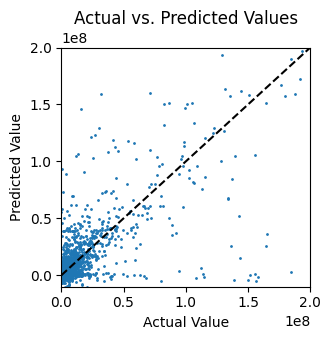

In [9]:
# Graph Model Results

# Plot the predicted values against the actual values
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax.scatter(y_test, y_pred, s=1)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
ax.set_title('Actual vs. Predicted Values')
# Plot the line y=x
ax.plot([0, 1e9], [0, 1e9], ls='--', c='k')
# Set the x and y limits
ax.set_xlim(0, 2e8)
ax.set_ylim(-1e7, 2e8)
fig.tight_layout()
plt.show()

In [24]:
# Output the features selected by the model
features = best_model.named_steps['selectpercentile'].get_support()
# print count of features selected
print(f"Number of features selected: {features.sum()}")

Number of features selected: 33
